In [136]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from itertools import product
import math 
from sklearn import metrics
from pprint import pp
    

In [137]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [138]:
def split_data(lst, pct):
    i = math.floor(len(lst) * pct)
    validation = lst[0 : i]
    test = lst[i : ]
    return test, validation

def is_valid(y):
    return all(x == y[0] for x in y)


def generate_data(n, size = 20, pct = 0):
    p = product(*(range(0, size+1) for _ in range(n)))
    data = set(x for x in p if 0 < sum(x) <= size )
    valid = set(y for y in data if is_valid(y))

    invalid = list(data - valid)
    valid = sorted(list(valid))
    
    if pct == 0:
        return invalid, valid
    
    invalid_test, invalid_validation = split_data(invalid, pct)

    valid_test, valid_validation = valid[0::2], valid[1::2]

    return (invalid_test, valid_test), (invalid_validation, valid_validation)

def sample(data):
    invalid, valid = data
    a = valid if np.random.rand() > 0.5 else invalid
    i = np.random.randint(len(a))
    return a[i]


def data_to_tensor(data):
    letters = sum(data)
    distinct_letters = len(data)
    tensor = torch.zeros(letters, distinct_letters)
    
    j = 0
    for i,chars in enumerate(data):
        for _ in range(chars):
            tensor[j][i] = 1
            j += 1

    return tensor


In [140]:
class Lambda(nn.Module):
    def __init__(self, fn):
        super(Lambda, self).__init__()
        self._name = 'lambda'
        self.fn = fn

    def forward(self, inputs):
        return self.fn(inputs)

class Debug(nn.Module):
    def __init__(self):
        super(Debug, self).__init__()
        self._name = 'debug'

    def forward(self, inputs):
        print(inputs)
        return inputs



def make_model(constructor, input_size):
    hidden_size = 5
    num_layers = 2
    rnn = constructor(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = 0.1)
    
    network = nn.Sequential(
        rnn,
        Lambda(lambda x : x[0][-1]),
        nn.Linear(in_features=hidden_size, out_features=1),
        # nn.ReLU(),
        # nn.Linear(in_features=2, out_features=1),
        nn.Sigmoid())
    
    return network

def debug(x, pre = ""):
    if pre != "":
        print("{}: {}".format(pre, x))
    else:
        print(x)
    return x

def flatten(x):
    return [a for y in x for a in y]

def predict(model, x):
    input_tensor = data_to_tensor(x)
    if gpu:
        input_tensor = input_tensor.to(device)
    output = model(input_tensor)

    return round(output[-1].item())

def predictions(model, xs):
    return [predict(model,x) for x in xs]

def get_labels(xs):
    return [int(is_valid(x)) for x in xs]

def merge(d, new_data):
    for k,v in new_data.items():
        if k not in d:
            d[k] = [v]
        else:
            d[k].append(v)
    return d


def calc_scores(model, data):
    score_fns = {
        "f1" : lambda lbls, preds : metrics.f1_score(lbls, preds, zero_division = 0),
        "accuracy" : metrics.accuracy_score,
        "precision" : lambda lbls, preds : metrics.precision_score(lbls, preds, zero_division = 0),
        "recall" : lambda lbls, preds : metrics.recall_score(lbls, preds, zero_division = 0),
        "confusion" : metrics.confusion_matrix
    }
    lbls = get_labels(data)
    preds = predictions(model, data)

    scores = {}
    for name, f in score_fns.items():
        scores[name] = f(lbls, preds)
    return scores


def train(model, data):
    train_data, validation_data = data
    flat_validation_data = flatten(validation_data)
    
    losses = []
    validation_scores = {}
    train_scores = {}

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0006)
    epochs = 300
    N = 150
    for epoch in range(epochs):
        running_loss = 0
        model.train()
        for _ in range(N):
            x = sample(train_data)
            valid = float(is_valid(x))
            label = torch.tensor([valid])
            input_tensor = data_to_tensor(x)
            if gpu:
                label = label.to(device)
                input_tensor = input_tensor.to(device)
                
            optimizer.zero_grad()
            output = model(input_tensor)
            y = output[-1]
            
            loss = criterion(y, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / N)
        model.eval()

        new_scores_validation = calc_scores(model, flat_validation_data)
        validation_scores = merge(validation_scores , new_scores_validation)

        new_scores_train = calc_scores(model, flatten(train_data))
        train_scores = merge(train_scores, new_scores_train)

        if epoch % 20 == 0:
            print("loss: {}".format(running_loss / N))
            print("train:")
            pp(new_scores_train)
            print("validation:")
            pp(new_scores_validation)


    return losses, { "validation_scores": validation_scores, "train_scores": train_scores }
    
    

In [141]:
# EXECUTE TRAINING

input_size = 2 
data = generate_data(input_size, 20, 0.3)
model = make_model(nn.RNN, input_size)
if gpu:
    model.to(device)
losses,scores = train(model, data)
model.eval()

loss: 0.7365835694471995
train:
{'f1': 0.06097560975609756,
 'accuracy': 0.031446540880503145,
 'precision': 0.031446540880503145,
 'recall': 1.0,
 'confusion': array([[  0, 154],
       [  0,   5]])}
validation:
{'f1': 0.13157894736842107,
 'accuracy': 0.07042253521126761,
 'precision': 0.07042253521126761,
 'recall': 1.0,
 'confusion': array([[ 0, 66],
       [ 0,  5]])}
loss: 0.5111480110883713
train:
{'f1': 0.18181818181818182,
 'accuracy': 0.7169811320754716,
 'precision': 0.1,
 'recall': 1.0,
 'confusion': array([[109,  45],
       [  0,   5]])}
validation:
{'f1': 0.0,
 'accuracy': 0.5070422535211268,
 'precision': 0.0,
 'recall': 0.0,
 'confusion': array([[36, 30],
       [ 5,  0]])}
loss: 0.2521228795746962
train:
{'f1': 0.2857142857142857,
 'accuracy': 0.8427672955974843,
 'precision': 0.16666666666666666,
 'recall': 1.0,
 'confusion': array([[129,  25],
       [  0,   5]])}
validation:
{'f1': 0.0,
 'accuracy': 0.5774647887323944,
 'precision': 0.0,
 'recall': 0.0,
 'confusion

KeyboardInterrupt: 

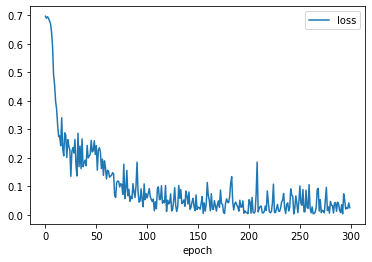

In [ ]:
plt.plot(losses, label="loss")
for name, data in scores.items():
    try: 
        plt.plot(data, label=name)
    except:
        pass
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
scores

{'validation_scores': {'f1': [0.13157894736842107,
   0.13157894736842107,
   0.13157894736842107,
   0.13157894736842107,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.10526315789473685,
   0.10256410256410256,
   0.06060606060606061,
   0.05405405405405406,
   0.06060606060606061,
   0.06060606060606061,
   0.08000000000000002,
   0.08000000000000002,
   0.06896551724137931,
   0.06896551724137931,
   0.07407407407407407,
   0.0,
   0.08695652173913045,
   0.06896551724137931,
   0.06451612903225806,
   0.07407407407407407,
   0.07407407407407407,
   0.10526315789473682,
   0.06666666666666667,
   0.06896551724137931,
   0.08333333333333333,
   0.06896551724137931,
   0.07142857142857142,
   0.07692307692307693,
   0.07142857142857142,
   0.0,
   0.08333333333333333,
   0.07142857142857142,
   0.08000000000000002,
   0.09523809523809523,
   0.06451612903225806,
   0.08695652173913045,
   0.07692307692307693,
   0.06451612903225806,
   0.06451612903225806,
   0.0769230769230769

In [ ]:
def split(f, xs):
    d = {}
    for x in xs:
        y = f(x)
        if y not in d:
            d[y] = [x]
        else:
            d[y].append(x)
    
    ys = sorted(d.items())
    return [y[1] for y in ys]

In [ ]:

all_data = split(sum, flatten(generate_data(2, 50)))
all_acc_scores = [calc_accuracy(model, d) for d in all_data]
all_f1_scores = [calc_f1(model, d) for d in all_data]


NameError: name 'calc_accuracy' is not defined

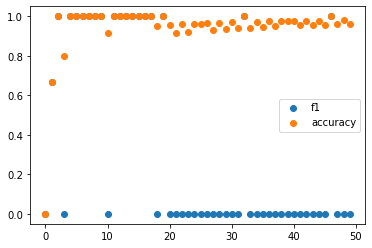

In [ ]:
x = range(len(all_data))
plt.scatter(x, all_f1_scores, label = "f1")
plt.scatter(x, all_acc_scores, label="accuracy")
plt.legend()

plt.show()

In [ ]:
predictions(model, all_data[1])

[1, 0, 1]

In [ ]:
get_labels(all_data[1])

[0, 0, 1]

In [ ]:
def f(i):
    print("data: {} \nlabels {} \npreds {}".format(all_data[i], get_labels(all_data[i]), predictions(model, all_data[i]) ) )

In [ ]:
f(7)

data: [(3, 5), (2, 6), (6, 2), (8, 0), (5, 3), (0, 8), (7, 1), (1, 7), (4, 4)] 
labels [0, 0, 0, 0, 0, 0, 0, 0, 1] 
preds [0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
f1_score([0,0], [0,0])

/home/dawg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.0

In [ ]:
predict(model, (5,5))

1

In [ ]:
f1_scores[2]

0.13157894736842107